In [1]:
import gc
import time
from tqdm import tqdm
import cv2
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input, AveragePooling2D
from keras.applications import inception_v3, resnet_v2
from keras.optimizers import Adam
from keras.callbacks import Callback

from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_0.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_1.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_2.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_3.feather
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train.csv


In [2]:
train_target = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv', index_col='image_id')

In [3]:
rootLB = LabelBinarizer()
vowelLB = LabelBinarizer()
consonantLB = LabelBinarizer()
rootLB.fit(train_target['grapheme_root'])
vowelLB.fit(train_target['vowel_diacritic'])
consonantLB.fit(train_target['consonant_diacritic'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

# Custom modules

## Custom metric callback

In [4]:
class validation_recall(keras.callbacks.Callback):
    
    def __init__(self, validation_data=()):
        super(keras.callbacks.Callback, self).__init__()
        self.X_val, self.y_val = validation_data
    
    def on_epoch_end(self, epoch, logs={}):

        root_val = self.y_val[0]
        vowel_val = self.y_val[1]
        consonant_val = self.y_val[2]
        
        # Predictions on validation set for the 3 targets 
        #(+ one hot encoding)
        preds = self.model.predict(self.X_val)
        
        root_preds = np.zeros_like(preds[0])
        root_preds[np.arange(len(preds[0])), 
                   preds[0].argmax(axis=1)] = 1
        
        vowel_preds = np.zeros_like(preds[1])
        vowel_preds[np.arange(len(preds[1])), 
                    preds[1].argmax(axis=1)] = 1
        
        consonant_preds = np.zeros_like(preds[2])
        consonant_preds[np.arange(len(preds[2])), 
                        preds[2].argmax(axis=1)] = 1
        
        # Recall calculation for the 3 targets
        root_recall = recall_score(root_val, root_preds, 
                                   average='macro')
        vowel_recall = recall_score(vowel_val, vowel_preds, 
                                    average='macro')
        consonant_recall = recall_score(consonant_val, consonant_preds, 
                                        average='macro')
        final_score = np.average([root_recall, vowel_recall, 
                                  consonant_recall], weights=[2,1,1])
        
        # Displaying scores at the end of each epoch
        print(' - root_recall: {0:.4f}'.format(root_recall)+\
              ' - vowel_recall: {0:.4f}'.format(vowel_recall)+\
              ' - consonant_recall: {0:.4f}'.format(consonant_recall)+\
              ' - final_score: {0:.4f}'.format(final_score))

        # Saving scores in logs history
        logs['root_recall'] = root_recall
        logs['vowel_recall'] = vowel_recall
        logs['consonant_recall'] = consonant_recall
        logs['final_score'] = final_score
        
        del root_val
        del vowel_val
        del consonant_val
        del preds 
        del root_preds 
        del vowel_preds
        del consonant_preds
        gc.collect()

## Custom data loader

Keras DataGenerator modified for multi-outputs model taken from [this very interesting notebook](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn#Basic-Model) from Kaushal Shah. It will allow to generate a batch of data to feed the model while training to avoid memory shortage.

In [5]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, 
                                         batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

## Resizing function

In [6]:
HEIGHT = 137
WIDTH = 236
CROP_SIZE = 80

In [7]:
def crop_and_resize_images(df, resized_df, resize_size = CROP_SIZE):
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = img[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size))
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
        
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df

# Model definition

In [8]:
def create_resnet50_model():
   
    inputs = Input(shape=(80,80,1))
    base_model = resnet_v2.ResNet50V2(include_top=False, weights=None, input_tensor=inputs, pooling='avg')
    x = base_model.output
    
    x = Dense(1024, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    
    root_out = Dense(168, activation='softmax', name='root_output')(x)
    vowel_out = Dense(11, activation='softmax', name='vowel_output')(x)
    consonant_out = Dense(7, activation='softmax', name='consonant_output')(x)

    model = Model(inputs=inputs, outputs=[root_out, vowel_out, consonant_out])
    
    return model

# Training function :

This training function is using the following process :
* Loading a set of images and targets data (from one of the four images files)
* Reshape images data to numpy array with correct dimensions (100 x 100)
* One hot encoding of the 3 targets
* Separate all sets in two : training set and validation set
* Creating Keras data generators to load data batch by batch in the model
* Train the model


In [9]:
def train_model(model, epochs, batch_size):
    complete_history = []
    for j in range(epochs):
        print('current epoch : ' + str(j+1) + ' / ' + str(epochs))
        for i in range(4):

            # Images + targets loading and merging
            train_data = pd.read_feather('/kaggle/input/bengali-graphemes-'
                                         'croppedresized-100x100-train/'
                                         f'train_data_{i}.feather')
            train_data.set_index(keys=['image_id'], drop=True, inplace=True)
            train_df = pd.merge(train_data, train_target, 
                                on='image_id').drop(['grapheme'], axis=1)

            # Deleting previous variables to free up memory
            del train_data
            gc.collect()

            # One hot encoding the 3 targets with sklearn LabelBinarizer
            #rootLB = LabelBinarizer()
            #vowelLB = LabelBinarizer()
            #consonantLB = LabelBinarizer()
            rootLabels = rootLB.transform(train_df['grapheme_root'])
            vowelLabels = vowelLB.transform(train_df['vowel_diacritic'])
            consonantLabels = consonantLB.transform(
                              train_df['consonant_diacritic'])

            # Reshape images data to numpy array with same dimensions 
            # as images (80 x 80)
            train_df.drop(['grapheme_root', 'vowel_diacritic', 
                           'consonant_diacritic'], axis=1, inplace=True)
            train_df = train_df / 255
            train_images = train_df.values.reshape(-1, 80, 80, 1)

            # Deleting previous variables to free up memory
            del train_df
            gc.collect()

            # Creating Train / validation set for images and 3 targets
            X_train, X_val, y_train_root, y_val_root, y_train_vowel, \
            y_val_vowel, y_train_consonant, y_val_consonant \
            = train_test_split(train_images, rootLabels, vowelLabels, 
                               consonantLabels, test_size=0.2, 
                               random_state=42)

            # Deleting previous variables to free up memory
            del train_images
            del rootLabels, vowelLabels, consonantLabels
            gc.collect()

            # Creation of Keras Datagenerator configuration 
            # without data augmentation
            datagen = MultiOutputDataGenerator(
            featurewise_center=False,  
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=0,
            zoom_range=0,
            width_shift_range=0,
            height_shift_range=0,
            horizontal_flip=False,
            vertical_flip=False)

            ''' You can use this piece of code to have insight of how the 
                datagen works and how batch are structured

            i = 0
            for batch in datagen.flow(X_train, 
                                     {'root': y_train_root, 
                                     'vowel': y_train_vowel, 
                                     'consonant': y_train_consonant},
                                      batch_size=1, save_to_dir=None):
                print(i)
                print('batch infos :')
                print(f'type : {type(batch)}')
                print(f'length type : {len(batch)}')
                print('features infos :')
                print(f'type : {type(batch[0])}')
                print(f'shape : {batch[0].shape}')
                print('Target infos :')
                print(f' global type : {type(batch[1])}')
                print(f'global shape : {len(batch[1])}')
                print(f'first target shape : {batch[1]["root"].shape}')
                print(f'second target shape : {batch[1]["vowel"].shape}')
                print(f'third target shape : {batch[1]["consonant"].shape}')

                i += 1
                if i > 5:
                    break  # otherwise the generator would loop indefinitely

            '''
            # creation of data generator for training set
            train_generator = datagen.flow(X_train,
                                           {'root_output': y_train_root, 
                                            'vowel_output': y_train_vowel, 
                                            'consonant_output': y_train_consonant},
                                           batch_size=batch_size)

            # creation of data generator for validation set
            val_generator = datagen.flow(X_val,
                                         {'root_output': y_val_root, 
                                          'vowel_output': y_val_vowel, 
                                          'consonant_output': y_val_consonant},
                                         batch_size=batch_size)

            # Creation of callback for metric calculation
            # after each epoch
            my_call = validation_recall(validation_data=(X_val,
                                                         [y_val_root,
                                                          y_val_vowel, 
                                                          y_val_consonant]))

            # Model training
            history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=1,
                    validation_data=val_generator,
                    validation_steps=X_val.shape[0] // batch_size,
                    callbacks=[my_call])

            # Appending training history to the one of previous
            complete_history.append(history.history)

            del train_generator
            del val_generator
            del my_call
            del X_train
            del X_val
            del y_train_root
            del y_val_root
            del y_train_vowel
            del y_val_vowel
            del y_train_consonant
            del y_val_consonant
            gc.collect()

    return model, complete_history

# Model training

In [10]:
model = create_resnet50_model()

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 86, 86, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 40, 40, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 42, 42, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=None)

In [13]:
trained_model, history = train_model(model=model, epochs=30, 
                                     batch_size=256)

current epoch : 1 / 30
Epoch 1/1
156/156 [==============================] - 86s 554ms/step - loss: 6.5687 - root_output_loss: 4.6147 - vowel_output_loss: 1.0602 - consonant_output_loss: 0.8937 - val_loss: 18.9867 - val_root_output_loss: 6.4568 - val_vowel_output_loss: 4.6282 - val_consonant_output_loss: 7.3862
 - root_recall: 0.0062 - vowel_recall: 0.1328 - consonant_recall: 0.1437 - final_score: 0.0722
Epoch 1/1
156/156 [==============================] - 60s 384ms/step - loss: 4.7054 - root_output_loss: 3.7389 - vowel_output_loss: 0.5105 - consonant_output_loss: 0.4560 - val_loss: 12.3040 - val_root_output_loss: 8.0822 - val_vowel_output_loss: 2.0240 - val_consonant_output_loss: 2.9606
 - root_recall: 0.0211 - vowel_recall: 0.4268 - consonant_recall: 0.4469 - final_score: 0.2290
Epoch 1/1
156/156 [==============================] - 60s 383ms/step - loss: 3.4483 - root_output_loss: 2.7178 - vowel_output_loss: 0.4037 - consonant_output_loss: 0.3268 - val_loss: 6.3276 - val_root_output_lo

In [14]:
trained_model.save('inception_V3.h5')

In [15]:
results_df = pd.DataFrame(columns=['val_loss', 'val_root_output_loss', 'val_vowel_output_loss',
                                   'val_consonant_output_loss', 'loss', 'root_output_loss',
                                   'vowel_output_loss', 'consonant_output_loss', 'root_recall',
                                   'vowel_recall', 'consonant_recall', 'final_score'])
for hist in history:
    results_df = results_df.append(pd.DataFrame(hist), ignore_index=True)

In [16]:
display(results_df)

,val_loss,val_root_output_loss,val_vowel_output_loss,val_consonant_output_loss,loss,root_output_loss,vowel_output_loss,consonant_output_loss,root_recall,vowel_recall,consonant_recall,final_score
0,18.986702,6.456827,4.628151,7.386230,6.568672,4.614731,1.060228,0.893715,0.006157,0.132837,0.143674,0.072207
1,12.303972,8.082202,2.024035,2.960560,4.705432,3.738934,0.510489,0.456008,0.021125,0.426850,0.446914,0.229003
2,6.327622,3.765799,1.796031,0.824327,3.448268,2.717797,0.403712,0.326759,0.167038,0.602173,0.608519,0.386192
3,5.237178,3.512211,1.150839,0.635650,2.519934,1.914972,0.338313,0.266649,0.250415,0.660979,0.745639,0.476862
4,1.759079,1.427374,0.274111,0.200735,1.978280,1.460981,0.287987,0.229311,0.530059,0.870334,0.912052,0.710626
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2.726543,0.792848,1.364321,0.211503,0.095826,0.058711,0.021461,0.015654,0.818856,0.790738,0.916072,0.836130
116,0.758353,0.504182,0.156542,0.167657,0.094036,0.059072,0.020046,0.014919,0.874548,0.958909,0.940597,0.912151
117,2.114332,0.910468,0.682586,0.519102,0.096772,0.060736,0.019327,0.016710,0.796275,0.884608,0.849056,0.831553
118,0.859228,0.564890,0.171521,0.133686,0.094142,0.055981,0.021096,0.017065,0.879955,0.957008,0.925774,0.910673


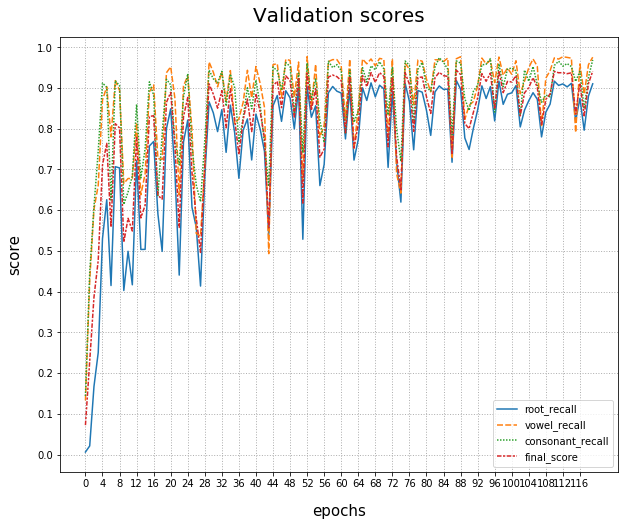

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.lineplot(data=results_df.loc[:,['root_recall', 'vowel_recall', 
                                         'consonant_recall', 'final_score']], linestyle=None)
ax.set_xlabel('epochs', labelpad=15, fontsize=15)
ax.set_ylabel('score', labelpad=15, fontsize=15)
ax.set_title('Validation scores', pad=15, fontsize=20)
plt.xticks(np.arange(0,results_df.shape[0],4))
plt.yticks(np.arange(0,1.1,0.1))
ax.grid(axis='both', linestyle=':', linewidth=1)

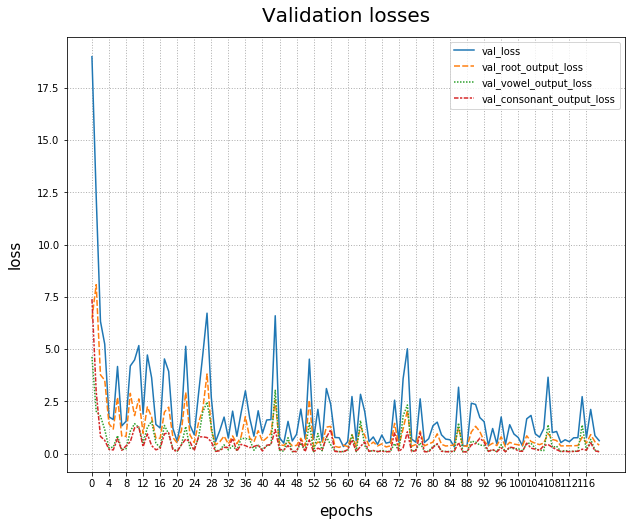

In [18]:
fig, ax1 = plt.subplots(figsize=(10,8))
ax1 = sns.lineplot(data=results_df.loc[:,['val_loss', 'val_root_output_loss', 'val_vowel_output_loss',
                                          'val_consonant_output_loss']], linestyle=None)
ax1.set_xlabel('epochs', labelpad=15, fontsize=15)
ax1.set_ylabel('loss', labelpad=15, fontsize=15)
ax1.set_title('Validation losses', pad=15, fontsize=20)
plt.xticks(np.arange(0,results_df.shape[0],4))
ax1.grid(axis='both', linestyle=':', linewidth=1)

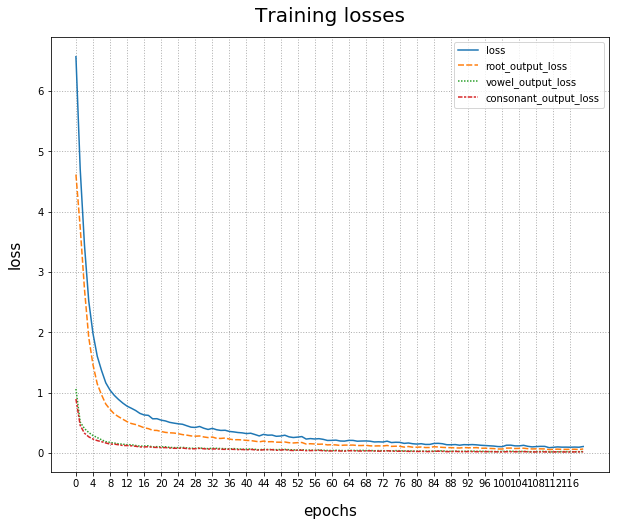

In [19]:
fig, ax2 = plt.subplots(figsize=(10,8))
ax2 = sns.lineplot(data=results_df.loc[:,['loss', 'root_output_loss','vowel_output_loss', 
                                          'consonant_output_loss']], linestyle=None)
ax2.set_xlabel('epochs', labelpad=15, fontsize=15)
ax2.set_ylabel('loss', labelpad=15, fontsize=15)
ax2.set_title('Training losses', pad=15, fontsize=20)
plt.xticks(np.arange(0,results_df.shape[0],4))
ax2.grid(axis='both', linestyle=':', linewidth=1)